In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)

########################################
# Step 1: Load Data and Convert Rating Columns to Float
########################################
df = pd.read_csv("( dataset created in Assignment 1)Scraped Full Dataset .csv")  # Adjust path if needed
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')

tnu = len(df)
tni = len(df.columns[3:])
print("Total number of users (tnu):", tnu)
print("Total number of items (tni):", tni)

item_rating_counts = df.iloc[:, 3:].notnull().sum()
print("\nNumber of ratings per item:")
print(item_rating_counts)

########################################
# Step 2: Define Active Users and Target Items, Introduce Missing Values
########################################
active_users_indices = [0, 1, 2]  # U1, U2, U3
target_items = [df.columns[3], df.columns[4]]  # I1 (4% missing), I2 (10% missing)
print("\nTarget Items:", target_items)

# Introduce missing ratings for active users
# U1: 2 missing, U2: 3 missing, U3: 5 missing
for (user_idx, missing_count) in zip(active_users_indices, [2, 3, 5]):
    missing_cols = np.random.choice(df.columns[3:], missing_count, replace=False)
    df.loc[user_idx, missing_cols] = np.nan

# Introduce missing ratings for target items (I1:4%, I2:10%)
for col, pm in zip(target_items, [4, 10]):
    num_missing = int(len(df) * (pm / 100))
    missing_rows = np.random.choice(df.index, num_missing, replace=False)
    df.loc[missing_rows, col] = np.nan

########################################
# Step 3: Introduce Additional Random Missing Values Across the Entire Dataset
########################################
missing_fraction = 0.10
ratings_data = df.iloc[:, 3:]
total_entries = ratings_data.size
num_additional_missing = int(total_entries * missing_fraction)

all_indices = [(i, j) for i in range(ratings_data.shape[0]) for j in range(ratings_data.shape[1])]
np.random.seed(42)
chosen_indices = np.random.choice(len(all_indices), num_additional_missing, replace=False)

for idx in chosen_indices:
    row_idx, col_idx = all_indices[idx]
    if not pd.isnull(ratings_data.iat[row_idx, col_idx]):
        ratings_data.iat[row_idx, col_idx] = np.nan

df.iloc[:, 3:] = ratings_data

print("\nUpdated Dataset with Additional Random Missing Values:")
print(df.head(10))

########################################
# Step 4: Normalize Ratings to 1-to-5 Scale
########################################
ratings_data = df.iloc[:, 3:]  # Extract the ratings columns

# Get the min and max values for normalization
min_rating = ratings_data.min().min()
max_rating = ratings_data.max().max()

print("\nMinimum rating:", min_rating)
print("Maximum rating:", max_rating)

# Apply normalization
ratings_data = (ratings_data - min_rating) / (max_rating - min_rating) * 4 + 1

# Ensure values are within the 1-to-5 range
ratings_data = ratings_data.clip(lower=1, upper=5)

# Replace the original data with normalized ratings
df.iloc[:, 3:] = ratings_data

print("\nNormalized Dataset (1-to-5 scale):")
print(df.head(10))

########################################
# Step 5: Save Modified Dataset
########################################
df.to_csv("modified_dataset.csv", index=False)
print("\nModified dataset saved to 'modified_dataset.csv'.")

########################################
# Step 5: Reload Modified Dataset and Prepare for Analysis
########################################
df_modified = pd.read_csv("modified_dataset.csv")
ratings_matrix = df_modified.iloc[:, 3:]





Total number of users (tnu): 50
Total number of items (tni): 138

Number of ratings per item:
kindness     50
abilities    50
activism     50
adulthood    50
adventure    50
             ..
world        50
write        50
writers      50
writing      50
yourself     50
Length: 138, dtype: int64

Target Items: ['kindness', 'abilities']

Updated Dataset with Additional Random Missing Values:
                                               Quote             Author  \
0  “The world as we have created it is a process ...    Albert Einstein   
1  “It is our choices, Harry, that show what we t...       J.K. Rowling   
2  “There are only two ways to live your life. On...    Albert Einstein   
3  “The person, be it gentleman or lady, who has ...        Jane Austen   
4  “Imperfection is beauty, madness is genius and...     Marilyn Monroe   
5  “Try not to become a man of success. Rather be...    Albert Einstein   
6  “It is better to be hated for what you are tha...         André Gide   
7  “I h

In [2]:

########################################
# Co-Rating Analysis
########################################
co_rating_data = []
for user_idx in active_users_indices:
    print(f"\nProcessing Active User (Index: {user_idx})")
    user_row = ratings_matrix.iloc[user_idx]
    rated_items = user_row.dropna().index
    co_rated = ratings_matrix.loc[:, rated_items].dropna(how='all')
    num_common_users = co_rated.shape[0] - 1
    num_coRated_items = co_rated.count().sum()
    co_rating_data.append((num_common_users, num_coRated_items))
    print(f"Number of common users: {num_common_users}, Co-rated items: {num_coRated_items}")

co_rating_array = np.array(sorted(co_rating_data, key=lambda x: x[0], reverse=True))
print("\nCo-Rating Analysis (2D Array):")
print(co_rating_array)

########################################
# Compute Threshold β for Each Active User
########################################
thresholds = []
for user_idx in active_users_indices:
    user_rated_count = ratings_matrix.iloc[user_idx].notnull().sum()
    user_coRated_items_list = [ci for (_, ci) in co_rating_data]
    beta = sum([1 for c_items in user_coRated_items_list if c_items >= 0.3 * user_rated_count])
    thresholds.append(beta)

print("\nThresholds (β) for Active Users:")
for i, beta in enumerate(thresholds):
    print(f"User {active_users_indices[i]}: {beta}")

########################################
# Helper Functions
########################################
def mean_center_user_matrix(ratings):
    """Mean-center user-based ratings by subtracting each user's mean rating."""
    user_means = ratings.mean(axis=1)
    centered = ratings.sub(user_means, axis=0).fillna(0)
    return centered, user_means

def pcc_similarity_user_based(centered_matrix):
    """Compute user-user PCC similarity from mean-centered data."""
    n_users = centered_matrix.shape[0]
    sim = np.zeros((n_users, n_users))
    vals = centered_matrix.values
    for i in range(n_users):
        for j in range(i+1, n_users):
            user_i = vals[i]
            user_j = vals[j]
            mask = (user_i != 0) & (user_j != 0)
            corr = pearsonr(user_i[mask], user_j[mask])[0] if np.sum(mask) > 1 else 0
            sim[i, j] = corr
            sim[j, i] = corr
    return pd.DataFrame(sim, index=centered_matrix.index, columns=centered_matrix.index)

def apply_discount_factor_user(sim_df, ratings, user_idx, thresholds, active_users_indices):
    """Apply user-based discount factor (DF) to similarities."""
    user_threshold = thresholds[active_users_indices.index(user_idx)]
    active_user_ratings = ratings.iloc[user_idx]
    active_mask = active_user_ratings.notnull()

    discounted_sim = sim_df[user_idx].copy()
    for neighbor_idx in ratings.index:
        if neighbor_idx == user_idx:
            discounted_sim.loc[neighbor_idx] = 0
            continue
        neighbor_ratings = ratings.iloc[neighbor_idx]
        co_rated_mask = active_mask & neighbor_ratings.notnull()
        co_rated_count = co_rated_mask.sum()
        DF = min(1, co_rated_count / user_threshold) if user_threshold > 0 else 1
        discounted_sim.loc[neighbor_idx] = sim_df.loc[neighbor_idx, user_idx] * DF
    return discounted_sim

def predict_missing_user_based(ratings, similarity_series, top_fraction=0.2):
    """Predict missing ratings for an active user using user-based approach."""
    n_users = len(ratings)
    top_n = int(top_fraction * n_users)
    top_neighbors = similarity_series.sort_values(ascending=False).head(top_n).index
    active_user_idx = similarity_series.name
    missing_items = ratings.iloc[active_user_idx][ratings.iloc[active_user_idx].isnull()].index

    predictions = {}
    for item in missing_items:
        numerator, denominator = 0, 0
        for nbr in top_neighbors:
            sim = similarity_series.loc[nbr]
            nbr_rating = ratings.loc[nbr, item]
            if not np.isnan(nbr_rating):
                numerator += sim * nbr_rating
                denominator += abs(sim)
        predictions[item] = numerator / denominator if denominator > 0 else np.nan
    return predictions

def mean_center_item_matrix(ratings):
    """Mean-center item-based ratings by subtracting each item's mean rating."""
    item_means = ratings.mean(axis=0)
    centered = ratings - item_means
    centered = centered.fillna(0)
    return centered.T, item_means

def pcc_similarity_item_based(centered_item_matrix):
    """Compute item-item PCC similarity from mean-centered data."""
    n_items = centered_item_matrix.shape[0]
    sim = np.zeros((n_items, n_items))
    vals = centered_item_matrix.values
    for i in range(n_items):
        for j in range(i+1, n_items):
            i_vals = vals[i]
            j_vals = vals[j]
            mask = (i_vals != 0) & (j_vals != 0)
            corr = pearsonr(i_vals[mask], j_vals[mask])[0] if np.sum(mask) > 1 else 0
            sim[i, j] = corr
            sim[j, i] = corr
    return pd.DataFrame(sim, index=centered_item_matrix.index, columns=centered_item_matrix.index)

def predict_missing_item_based(ratings, item_similarity_df, target_items, fraction=0.2):
    """Predict missing ratings for target items using item-based approach."""
    n_items = len(item_similarity_df.index)
    top_n = int(fraction * n_items)
    item_preds = {}
    for item in target_items:
        similar_items = item_similarity_df[item].sort_values(ascending=False).iloc[1:top_n+1]
        for user_idx in ratings.index:
            if np.isnan(ratings.loc[user_idx, item]):
                numerator, denominator = 0, 0
                for sim_item, sim_score in similar_items.items():
                    usr_rating = ratings.loc[user_idx, sim_item]
                    if not np.isnan(usr_rating):
                        numerator += sim_score * usr_rating
                        denominator += abs(sim_score)
                if user_idx not in item_preds:
                    item_preds[user_idx] = {}
                item_preds[user_idx][item] = numerator / denominator if denominator > 0 else np.nan
    return item_preds

def apply_discount_factor_item(sim_df, ratings, target_item, beta):
    """Apply item-based discount factor (DF) to similarities."""
    discounted_sim = sim_df[target_item].copy()
    target_item_ratings = ratings[target_item]
    target_item_mask = target_item_ratings.notnull()

    for other_item in sim_df.index:
        if other_item == target_item:
            discounted_sim.loc[other_item] = 0
            continue
        other_ratings = ratings[other_item]
        co_rated_mask = target_item_mask & other_ratings.notnull()
        co_rated_users_count = co_rated_mask.sum()
        DF = min(1, co_rated_users_count / beta) if beta > 0 else 1
        discounted_sim.loc[other_item] = sim_df.loc[other_item, target_item] * DF
    return discounted_sim

def compute_item_threshold(ratings, target_item):
    """Compute β for items similarly to user-based threshold logic."""
    target_item_ratings = ratings[target_item]
    target_item_mask = target_item_ratings.notnull()
    users_who_rated_target = target_item_mask.sum()
    count_30 = 0.3 * users_who_rated_target

    co_rated_counts = []
    for other_item in ratings.columns:
        if other_item == target_item:
            continue
        other_mask = ratings[other_item].notnull()
        co_rated_users_count = (target_item_mask & other_mask).sum()
        co_rated_counts.append(co_rated_users_count)

    beta_item = sum([1 for c in co_rated_counts if c >= count_30])
    return beta_item




Processing Active User (Index: 0)
Number of common users: 49, Co-rated items: 5352

Processing Active User (Index: 1)
Number of common users: 49, Co-rated items: 5487

Processing Active User (Index: 2)
Number of common users: 49, Co-rated items: 5590

Co-Rating Analysis (2D Array):
[[  49 5352]
 [  49 5487]
 [  49 5590]]

Thresholds (β) for Active Users:
User 0: 3
User 1: 3
User 2: 3


In [3]:
########################################
# Create Similarity Matrices (User-User)
########################################
filled_ratings_matrix = ratings_matrix.fillna(0)
cosine_no_bias_array = cosine_similarity(filled_ratings_matrix)
cosine_no_bias_df = pd.DataFrame(cosine_no_bias_array, index=ratings_matrix.index, columns=ratings_matrix.index)

centered_user_matrix, user_means = mean_center_user_matrix(ratings_matrix)
cosine_centered_array = cosine_similarity(centered_user_matrix)
cosine_centered_df = pd.DataFrame(cosine_centered_array, index=ratings_matrix.index, columns=ratings_matrix.index)

pcc_user_sim_df = pcc_similarity_user_based(centered_user_matrix)

########################################
# Case Study 1.1: Cosine No Bias with DF
########################################
user_based_df_predictions_1_1 = {}
for user_idx in active_users_indices:
    discounted_sim = apply_discount_factor_user(cosine_no_bias_df, ratings_matrix, user_idx, thresholds, active_users_indices)
    discounted_sim.name = user_idx
    user_based_df_predictions_1_1[user_idx] = predict_missing_user_based(ratings_matrix, discounted_sim)

print("\nUser-Based Predictions (Cosine No Bias + DF) [Case 1.1]:")
for u, preds in user_based_df_predictions_1_1.items():
    print(f"User {u}: {preds}")

########################################
# Case Study 1.2: Cosine + Mean-Centering + DF
########################################
user_based_df_predictions_1_2 = {}
for user_idx in active_users_indices:
    discounted_sim = apply_discount_factor_user(cosine_centered_df, ratings_matrix, user_idx, thresholds, active_users_indices)
    discounted_sim.name = user_idx
    user_based_df_predictions_1_2[user_idx] = predict_missing_user_based(ratings_matrix, discounted_sim)

print("\nUser-Based Predictions (Cosine + Mean-Centering + DF) [Case 1.2]:")
for u, preds in user_based_df_predictions_1_2.items():
    print(f"User {u}: {preds}")

########################################
# Case Study 1.3: PCC + Mean-Centering (No DF and With DF)
########################################
# No DF:
pcc_no_df_preds = {}
for user_idx in active_users_indices:
    sim_series = pcc_user_sim_df[user_idx]
    sim_series.name = user_idx
    pcc_no_df_preds[user_idx] = predict_missing_user_based(ratings_matrix, sim_series)

# With DF:
pcc_with_df_preds = {}
for user_idx in active_users_indices:
    discounted_sim = apply_discount_factor_user(pcc_user_sim_df, ratings_matrix, user_idx, thresholds, active_users_indices)
    discounted_sim.name = user_idx
    pcc_with_df_preds[user_idx] = predict_missing_user_based(ratings_matrix, discounted_sim)

print("\nUser-Based Predictions (PCC + Mean-Centering, No DF) [Case 1.3]:")
for u, preds in pcc_no_df_preds.items():
    print(f"User {u}: {preds}")

print("\nUser-Based Predictions (PCC + Mean-Centering + DF) [Case 1.3]:")
for u, preds in pcc_with_df_preds.items():
    print(f"User {u}: {preds}")

########################################
# Create Similarity Matrices (Item-Item)
########################################
item_filled = ratings_matrix.fillna(0).T
cosine_no_bias_item_array = cosine_similarity(item_filled)
cosine_no_bias_item_df = pd.DataFrame(cosine_no_bias_item_array, index=ratings_matrix.columns, columns=ratings_matrix.columns)

centered_item_matrix, item_means = mean_center_item_matrix(ratings_matrix)
cosine_centered_item_array = cosine_similarity(centered_item_matrix)
cosine_centered_item_df = pd.DataFrame(cosine_centered_item_array, index=centered_item_matrix.index, columns=centered_item_matrix.index)

pcc_item_sim_df = pcc_similarity_item_based(centered_item_matrix)

########################################
# Case Study 2.1: Item-based Cosine No Bias with DF (Top 25%)
########################################
item_based_df_predictions_2_1 = {}
for item in target_items:
    beta_item = compute_item_threshold(ratings_matrix, item)
    discounted_sim_item = apply_discount_factor_item(cosine_no_bias_item_df, ratings_matrix, item, beta_item)
    discounted_sim_item.name = item
    n_items = len(cosine_no_bias_item_df.index)
    top_25 = int(0.25 * n_items)
    sorted_sim = discounted_sim_item.sort_values(ascending=False)

    item_based_df_predictions_2_1_part = {}
    for user_idx in ratings_matrix.index:
        if np.isnan(ratings_matrix.loc[user_idx, item]):
            numerator, denominator = 0, 0
            for sim_item, sim_score in sorted_sim.iloc[1:top_25+1].items():
                usr_rating = ratings_matrix.loc[user_idx, sim_item]
                if not np.isnan(usr_rating):
                    numerator += sim_score * usr_rating
                    denominator += abs(sim_score)
            if user_idx not in item_based_df_predictions_2_1_part:
                item_based_df_predictions_2_1_part[user_idx] = {}
            item_based_df_predictions_2_1_part[user_idx][item] = numerator / denominator if denominator > 0 else np.nan
    item_based_df_predictions_2_1[item] = item_based_df_predictions_2_1_part

print("\nItem-Based Predictions (Cosine No Bias + DF) [Case 2.1]:")
for item in target_items:
    print(f"Item {item}:")
    for user, preds in item_based_df_predictions_2_1[item].items():
        print(f"User {user}: {preds}")

########################################
# Case Study 2.2: Item-based Cosine + Mean-Centering
# Top 20%
########################################
top_20 = int(0.2 * len(cosine_centered_item_df.index))
item_based_centered_preds_2_2 = predict_missing_item_based(ratings_matrix, cosine_centered_item_df, target_items, fraction=0.2)
print("\nItem-Based Predictions (Cosine + Mean-Centering, No DF) [Case 2.2]:")
for u, preds in item_based_centered_preds_2_2.items():
    print(f"User {u}: {preds}")

# With DF for 2.2
item_based_df_predictions_2_2 = {}
for item in target_items:
    beta_item = compute_item_threshold(ratings_matrix, item)
    discounted_sim_item = apply_discount_factor_item(cosine_centered_item_df, ratings_matrix, item, beta_item)
    discounted_sim_item.name = item
    sorted_sim = discounted_sim_item.sort_values(ascending=False)

    item_based_df_predictions_2_2_part = {}
    for user_idx in ratings_matrix.index:
        if np.isnan(ratings_matrix.loc[user_idx, item]):
            numerator, denominator = 0,0
            for sim_item, sim_score in sorted_sim.iloc[1:top_20+1].items():
                usr_rating = ratings_matrix.loc[user_idx, sim_item]
                if not np.isnan(usr_rating):
                    numerator += sim_score * usr_rating
                    denominator += abs(sim_score)
            if user_idx not in item_based_df_predictions_2_2_part:
                item_based_df_predictions_2_2_part[user_idx] = {}
            item_based_df_predictions_2_2_part[user_idx][item] = numerator/denominator if denominator>0 else np.nan
    item_based_df_predictions_2_2[item] = item_based_df_predictions_2_2_part

print("\nItem-Based Predictions (Cosine + Mean-Centering + DF) [Case 2.2]:")
for item in target_items:
    print(f"Item {item}:")
    for user, preds in item_based_df_predictions_2_2[item].items():
        print(f"User {user}: {preds}")

########################################
# Case Study 2.3: PCC Item-based
# Top 20%
########################################
item_based_pcc_preds_2_3 = predict_missing_item_based(ratings_matrix, pcc_item_sim_df, target_items, fraction=0.2)
print("\nItem-Based Predictions (PCC + Mean-Centering, No DF) [Case 2.3]:")
for u, preds in item_based_pcc_preds_2_3.items():
    print(f"User {u}: {preds}")

# With DF for 2.3
item_based_df_predictions_2_3 = {}
for item in target_items:
    beta_item = compute_item_threshold(ratings_matrix, item)
    discounted_pcc_item = apply_discount_factor_item(pcc_item_sim_df, ratings_matrix, item, beta_item)
    discounted_pcc_item.name = item
    sorted_sim = discounted_pcc_item.sort_values(ascending=False)

    item_based_df_predictions_2_3_part = {}
    for user_idx in ratings_matrix.index:
        if np.isnan(ratings_matrix.loc[user_idx, item]):
            numerator, denominator=0,0
            for sim_item, sim_score in sorted_sim.iloc[1:top_20+1].items():
                usr_rating = ratings_matrix.loc[user_idx, sim_item]
                if not np.isnan(usr_rating):
                    numerator+= sim_score*usr_rating
                    denominator+=abs(sim_score)
            if user_idx not in item_based_df_predictions_2_3_part:
                item_based_df_predictions_2_3_part[user_idx]={}
            item_based_df_predictions_2_3_part[user_idx][item] = numerator/denominator if denominator>0 else np.nan
    item_based_df_predictions_2_3[item] = item_based_df_predictions_2_3_part

print("\nItem-Based Predictions (PCC + Mean-Centering + DF) [Case 2.3]:")
for item in target_items:
    print(f"Item {item}:")
    for user, preds in item_based_df_predictions_2_3[item].items():
        print(f"User {user}: {preds}")




User-Based Predictions (Cosine No Bias + DF) [Case 1.1]:
User 0: {'change': 2.9962316694255384, 'chocolate': 3.683296117321408, 'comedy': 2.3799230806378, 'dreaming': 3.124989127025647, 'elizabeth-bennet': 3.115680173236061, 'faith': 2.490696909415585, 'good': 3.000850922218363, 'inspiration': 2.5938085443639824, 'literature': 3.442378841356817, 'marriage': 2.562804295201876, 'mind': 2.995125880226595, 'misattributed-to-mother-teresa': 2.2321649071858576, 'navigation': 2.696680105999684, 'obvious': 3.451174597163672, 'opposite': 2.702408046880986, 'paraphrased': 1.7107849522667615, 'poetry': 3.125991132916389, 'sisters': 2.7872502961540797, 'women': 2.38909676031415}
User 1: {'be-yourself': 2.4018536114024163, 'children': 2.1983278696168664, 'dreamers': 2.4855623085810246, 'dreaming': 2.7872285660602047, 'education': 2.780294052244144, 'fairy-tales': 2.571257351903889, 'faith': 2.4875023360417785, 'insanity': 2.2668062650552776, 'inspiration': 2.8134838293239444, 'library': 2.65131812

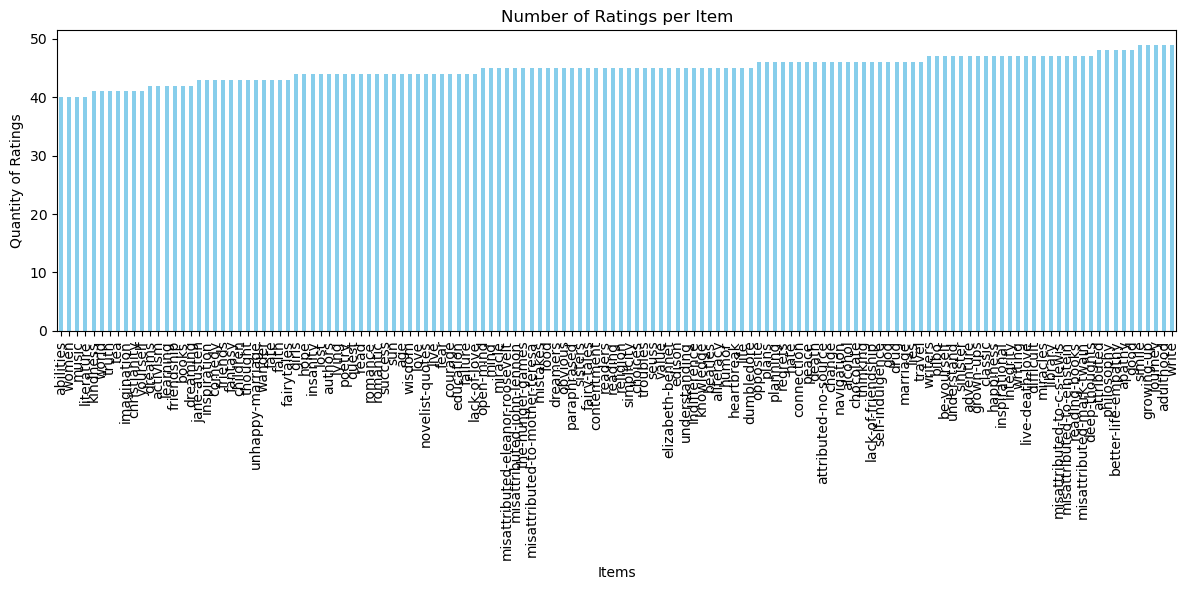

In [4]:
########################################
# Plot Number of Ratings per Item
########################################


item_counts = df.iloc[:, 3:].notnull().sum().sort_values()

plt.figure(figsize=(12, 6))
item_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Ratings per Item')
plt.xlabel('Items')
plt.ylabel('Quantity of Ratings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
